# Financial Derivatives and Risk Management
## Group Assignment - Option Pricing: Cryptocurrencies (June 2024)
### Authors:
- Luís Ribeiro (nº 20231536)
- Renato Morais (nº 20231135)
- Fernando Tiago (nº 20231535)
- Thiago Bellas (nº 20231131)
- Saad Islam (nº 20230513)

---------------------------------------

## 1) Pick a cryptocurrency (Bitcoin or Ethereum) you will analyze. Use Deribit to collect prices for put and call options for your selected cryptocurrency that are near the money (closest strike price to current price) for the different time periods (1 day to 4 Quarters) available. Assume the cryptocurrency follows a log-normal model (geometric Brownian motion).

For obtaining data from Deribit, we used their REST API. First getting the whole option chain, then filtering to those near the money and finally getting data for the remaining instruments.

In [1]:
!pip install requests
import requests
import pandas as pd
import datetime
import numpy as np

#don't warn about SSL verification
import warnings
from requests.packages.urllib3.exceptions import InsecureRequestWarning
warnings.simplefilter('ignore',InsecureRequestWarning)


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%%time
import requests
import datetime
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import threading

#fetch instrument data
def fetch_deribit_instrument_data(instrument: str):
    response = requests.get(f"https://www.deribit.com/api/v2/public/ticker?instrument_name={instrument}", verify=False)
    return response.json()['result']

#fell ALL of the option chain
def fetch_deribit_option_data(tolerance=0.05, max_workers=10):
    url = "https://www.deribit.com/api/v2/public/get_instruments?currency=BTC&kind=option&expired=false"
    response = requests.get(url, verify=False)
    response_objects = response.json()['result']

    option_types, instrument_ids, strikes = [], [], []
    expiration_timestamps, instrument_names = [], []
    underlyings, index_prices, prices_btc = [], [], []
    prices_usd, usd_btc_rates= [], []

    #for maturity, get underlying and reduce lookups of instruments...
    underlying_map = {}
    #ensure thread safety on map since we're looking it up concurrently... (computer science thingy)
    map_lock = threading.Lock()

    #for each instrument, if there's no underlying already registered to maturity then lookup & add underlying to map; if there is, skip to next step
    #if near the money, process it.
    def process_instrument(obj):
        nonlocal underlying_map
        instrument_data = None
        
        if obj['expiration_timestamp'] not in underlying_map:
            instrument_data = fetch_deribit_instrument_data(obj['instrument_name'])
            with map_lock:
                underlying_map[obj['expiration_timestamp']] = instrument_data['underlying_price']
        
        with map_lock:
            underlying_price = underlying_map[obj['expiration_timestamp']]

        if abs(obj['strike'] - underlying_price) < underlying_price * tolerance:
            if instrument_data == None: #avoid looking twice
                instrument_data = fetch_deribit_instrument_data(obj['instrument_name'])

            # General options
            instrument_names.append(obj['instrument_name'])
            option_types.append(obj['option_type'])
            instrument_ids.append(obj['instrument_id'])
            strikes.append(obj['strike'])
            expiration_timestamps.append(datetime.datetime.fromtimestamp(obj['expiration_timestamp'] / 1000))

            # Instrument specific
            underlyings.append(instrument_data['underlying_price'])
            prices_btc.append(instrument_data['mark_price'])

            # Convert from BTC to USD prices
            index_prices.append(instrument_data['index_price'])
            prices_usd.append(round(instrument_data['mark_price'] * instrument_data['index_price'], 4))

    # Use ThreadPoolExecutor for concurrent data fetching
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        executor.map(process_instrument, response_objects)

    # Create DataFrame from the collected data
    all_options = pd.DataFrame(
        data={
            "type": option_types,
            "strike": strikes,
            "expiry": expiration_timestamps,
            "name": instrument_names,
            "underlying": underlyings,
            "index_price": index_prices,
            "mark_price_btc": prices_btc,
            "mark_price_usd": prices_usd
        },
        index=instrument_ids
    ).sort_values(['strike', 'expiry', 'type'])

    return all_options

# Execute the optimized function
options_df = fetch_deribit_option_data()
options_df

CPU times: total: 5.16 s
Wall time: 7.95 s


,type,strike,expiry,name,underlying,index_price,mark_price_btc,mark_price_usd
339957,call,57000.0,2024-06-25 09:00:00,BTC-25JUN24-57000-C,59348.4150,59343.77,0.0403,2391.5539
339960,put,57000.0,2024-06-25 09:00:00,BTC-25JUN24-57000-P,59348.4150,59343.77,0.0008,47.4750
340287,call,57000.0,2024-06-26 09:00:00,BTC-26JUN24-57000-C,59369.6867,59343.77,0.0429,2545.8477
340288,put,57000.0,2024-06-26 09:00:00,BTC-26JUN24-57000-P,59369.6867,59343.77,0.0030,178.0313
340467,call,57000.0,2024-06-27 09:00:00,BTC-27JUN24-57000-C,59379.8898,59317.88,0.0454,2693.0318
...,...,...,...,...,...,...,...,...
287310,put,63000.0,2024-12-27 08:00:00,BTC-27DEC24-63000-P,62511.1100,59285.30,0.1790,10612.0687
285066,call,65000.0,2024-12-27 08:00:00,BTC-27DEC24-65000-C,62511.1100,59285.30,0.1595,9456.0054
285067,put,65000.0,2024-12-27 08:00:00,BTC-27DEC24-65000-P,62511.1100,59285.30,0.1990,11797.7747
309018,call,65000.0,2025-03-28 08:00:00,BTC-28MAR25-65000-C,64224.0000,59285.30,0.2163,12823.4104


### a) Estimate volatility using different historical time series of varying lengths

We have an option chain of various maturities. The step of calculating volatility using different historical time series of varying lengths is important so we have an historical volatility for each point in time.
For more accuracy, we are estimating volatility (historical lookback) for everyday for 2 years.

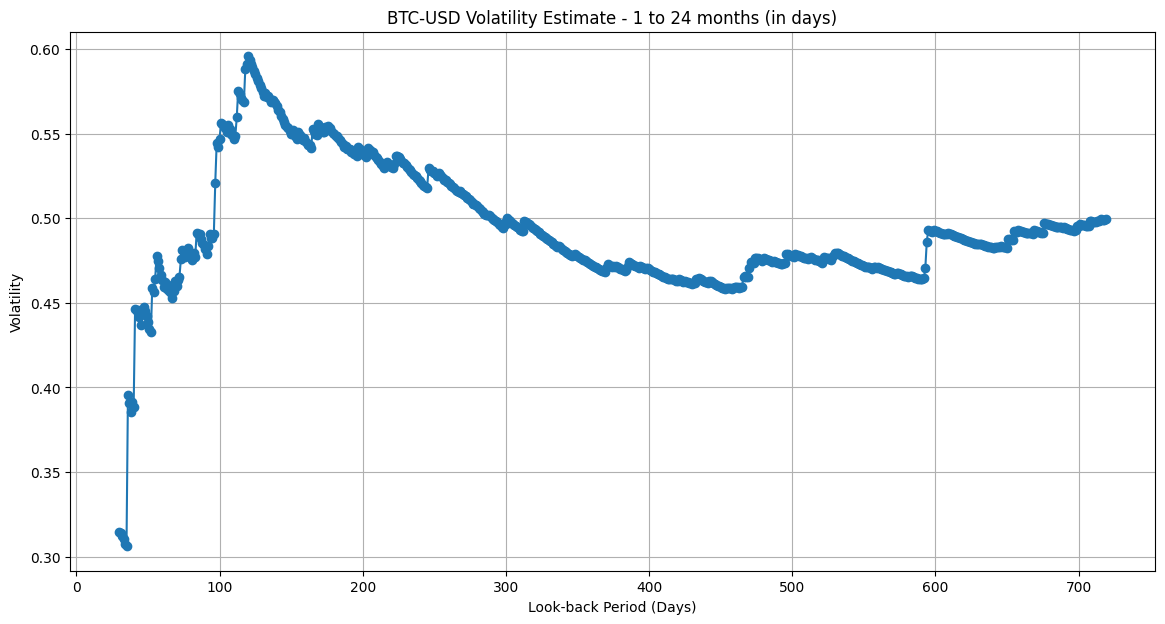

In [3]:
import yfinance as yf
import matplotlib.pyplot as plt

returns = yf.download('BTC-USD', progress=False)['Close'] \
    .pct_change() \
    .dropna()
log_returns = np.log(returns + 1)

look_back_volatility = {}
for days in range(30, 24 * 30):
    #annualize volatility
    look_back_volatility[days] = log_returns.iloc[-days:].std() * np.sqrt(365)

# Create a DataFrame from the look-back volatility dictionary
volatility_df = pd.DataFrame(list(look_back_volatility.items()), columns=['Months', 'Volatility'])

# Plot the look-back period volatility
plt.figure(figsize=(14, 7))
plt.plot(volatility_df['Months'], volatility_df['Volatility'], marker='o')
plt.title('BTC-USD Volatility Estimate - 1 to 24 months (in days)')
plt.xlabel('Look-back Period (Days)')
plt.ylabel('Volatility')
plt.grid(True)
plt.show()

Above can be seen the BTC/USD lookback volatility for an increasing amount of days. We have started at 30 days since realistically we can only get bond yields starting at that period - this is important since we will first evaluate options using a US T-Bill yield for risk free rates.
In any case, as seen above, our volatility estimate peaks a bit after 100 days taking a curve shape after that.

### b) Calculate the implied volatility for different option lengths and compare to the historical volatility. What does this tell you?

The implied volatility is the actual volatility being used by the market to price the options. In other words: it's the real volatility.
To calculate it, we must first get a option price by any methodology and then vary the volatility being used in our pricing model until the premiums match (the computed and real one).
To compute the option premiums, we will use the Black-Scholes Model, being defined below:

In [4]:
import seaborn as sns
from scipy.optimize import fsolve
from scipy.stats import norm

def bsm_call_price(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    C = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return C

def bsm_put_price(S0, K, T, r, sigma):
    #just use put-call-parity for computational speed, market is liquid
    C = bsm_call_price(S0, K, T, r, sigma)
    return C - S0 + K * np.exp(-r*T)

Next, we need to compute the maturity/tenor of the option contracts in years. These options are different from stock options, one of the differences being that they're traded 24/7.
To reflect this nature of the options, and the fact that Deribit measures maturity in days, hours, and minutes, we will calculate the number of minutes in the tenor of the contracts against the number of minutes in a year.

In [5]:
options_df['expiry_T'] = options_df.expiry.apply(lambda exp: ((exp - datetime.datetime.now()).total_seconds()/60) / (365 * 24 * 60))
options_df


,type,strike,expiry,name,underlying,index_price,mark_price_btc,mark_price_usd,expiry_T
339957,call,57000.0,2024-06-25 09:00:00,BTC-25JUN24-57000-C,59348.4150,59343.77,0.0403,2391.5539,0.001363
339960,put,57000.0,2024-06-25 09:00:00,BTC-25JUN24-57000-P,59348.4150,59343.77,0.0008,47.4750,0.001363
340287,call,57000.0,2024-06-26 09:00:00,BTC-26JUN24-57000-C,59369.6867,59343.77,0.0429,2545.8477,0.004103
340288,put,57000.0,2024-06-26 09:00:00,BTC-26JUN24-57000-P,59369.6867,59343.77,0.0030,178.0313,0.004103
340467,call,57000.0,2024-06-27 09:00:00,BTC-27JUN24-57000-C,59379.8898,59317.88,0.0454,2693.0318,0.006842
...,...,...,...,...,...,...,...,...,...
287310,put,63000.0,2024-12-27 08:00:00,BTC-27DEC24-63000-P,62511.1100,59285.30,0.1790,10612.0687,0.508098
285066,call,65000.0,2024-12-27 08:00:00,BTC-27DEC24-65000-C,62511.1100,59285.30,0.1595,9456.0054,0.508098
285067,put,65000.0,2024-12-27 08:00:00,BTC-27DEC24-65000-P,62511.1100,59285.30,0.1990,11797.7747,0.508098
309018,call,65000.0,2025-03-28 08:00:00,BTC-28MAR25-65000-C,64224.0000,59285.30,0.2163,12823.4104,0.757413


Next, we need a risk-free rate.
This is an interesting topic, as will be discussed later on, but for initial calculations we have used the standard US Treasury Bill yields.
Since we have various option contracts of various maturities, we need to estimate the yields for each maturity. To solve this, we have retrieved the current rates and interpolated them. This is because, in theory, the risk free rate should match the maturity of an investment. 


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Rates are empty, retrieving it...


c:\Python310\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


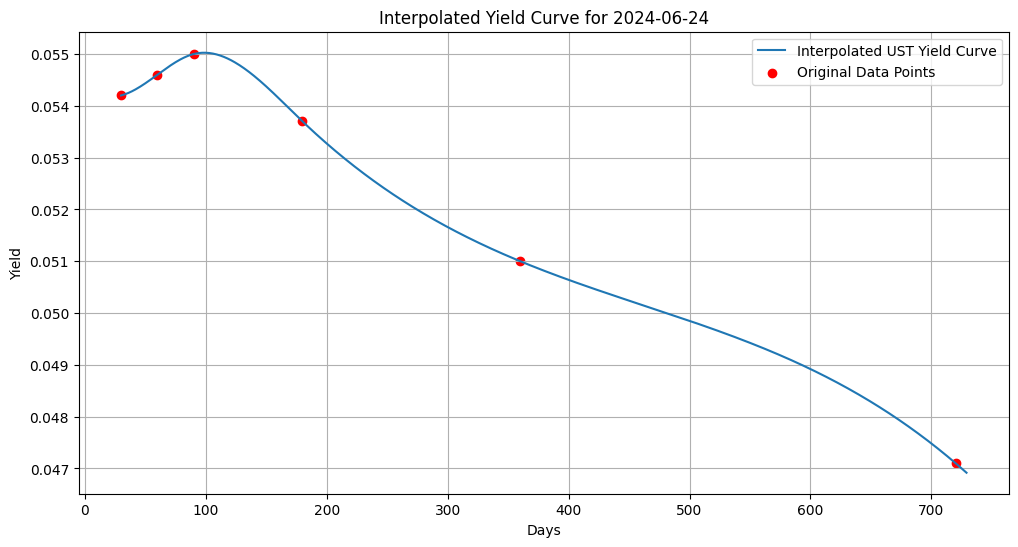

In [6]:
!pip install ustreasurycurve

import ustreasurycurve as ustcurve
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

#get rates up to today
today = datetime.datetime.now().strftime('%Y-%m-%d')

#if rates are null, fill them...
print("Rates are empty, retrieving it...")
rates_obj = ustcurve.nominalRates('2024-01-01', today, False)[["date", "1m", "2m", "3m", "6m", "1y", "2y"]]
rates_obj.rename(columns={"1m": 30, "2m": 60, "3m": 90, "6m": 180, "1y": 360, "2y": 720}, inplace=True)
rates_obj.set_index('date', inplace=True)

#form curve
ust_curve = CubicSpline(rates_obj.columns, rates_obj.values[-1])

#create easy function
def get_risk_free_rate(days):
    return ust_curve(days) * 1

#plot curve
plt.figure(figsize=(12, 6))
plt.plot(np.arange(30, 365 * 2), get_risk_free_rate(np.arange(30, 365 * 2)), label='Interpolated UST Yield Curve')
plt.scatter(rates_obj.columns, rates_obj.values[-1], color='red', label='Original Data Points')
plt.xlabel('Days')
plt.ylabel('Yield')
plt.title(f'Interpolated Yield Curve for {today}')
plt.legend()
plt.grid(True)
plt.show()

As mentioned before, since we only have yields starting at 1 month, we need to filter out option contracts expiring before 1 month.
Next, we can finally, given the number of days remaining, estimate the risk-free rate and the historical lookback volatility.

In [7]:
#filter options expiring at least 1 month out
options_atleast_1mo_df = options_df[options_df['expiry_T'] > 1/12].copy()

options_atleast_1mo_df['ust_rate'] = (options_atleast_1mo_df['expiry_T'] * 365) \
  .astype('int') \
  .apply(get_risk_free_rate)

options_atleast_1mo_df['historical_volatility'] = (options_atleast_1mo_df['expiry_T'] * 365) \
.astype('int') \
.apply(lambda t_days: look_back_volatility[t_days])

options_atleast_1mo_df.head(10)

,type,strike,expiry,name,underlying,index_price,mark_price_btc,mark_price_usd,expiry_T,ust_rate,historical_volatility
320446,call,57000.0,2024-07-26 09:00:00,BTC-26JUL24-57000-C,59811.5900,59301.53,0.0841,4987.2587,0.086294,0.054206,0.314056
320447,put,57000.0,2024-07-26 09:00:00,BTC-26JUL24-57000-P,59811.5900,59301.53,0.0371,2200.0868,0.086294,0.054206,0.314056
320144,call,58000.0,2024-07-26 09:00:00,BTC-26JUL24-58000-C,59811.5900,59301.53,0.0742,4400.1735,0.086294,0.054206,0.314056
320145,put,58000.0,2024-07-26 09:00:00,BTC-26JUL24-58000-P,59811.5900,59301.53,0.0439,2603.3372,0.086294,0.054206,0.314056
332364,call,58000.0,2024-08-30 09:00:00,BTC-30AUG24-58000-C,60404.8189,59286.43,0.1093,6480.0068,0.182185,0.054701,0.455834
332365,put,58000.0,2024-08-30 09:00:00,BTC-30AUG24-58000-P,60404.8189,59286.43,0.0695,4120.4069,0.182185,0.054701,0.455834
286053,call,58000.0,2024-09-27 09:00:00,BTC-27SEP24-58000-C,60881.6500,59286.43,0.1351,8009.5967,0.258897,0.055018,0.488407
286054,put,58000.0,2024-09-27 09:00:00,BTC-27SEP24-58000-P,60881.6500,59286.43,0.0878,5205.3486,0.258897,0.055018,0.488407
320146,call,59000.0,2024-07-26 09:00:00,BTC-26JUL24-59000-C,59811.5900,59301.53,0.0651,3860.5296,0.086294,0.054206,0.314056
320147,put,59000.0,2024-07-26 09:00:00,BTC-26JUL24-59000-P,59811.5900,59301.53,0.0516,3059.9589,0.086294,0.054206,0.314056


We can now apply the BSM model to compute the premiums:

In [8]:
#calculate BSM prices for calls and puts
options_atleast_1mo_df['bsm_price'] = np.where(
    #condition
    options_atleast_1mo_df['type'] == "call",
    #if condition
    bsm_call_price(
        options_atleast_1mo_df['underlying'],
        options_atleast_1mo_df['strike'],
        options_atleast_1mo_df['expiry_T'],
        options_atleast_1mo_df['ust_rate'],
        options_atleast_1mo_df['historical_volatility']
    ),
    #if not condition
    bsm_put_price(
        options_atleast_1mo_df['underlying'],
        options_atleast_1mo_df['strike'],
        options_atleast_1mo_df['expiry_T'],
        options_atleast_1mo_df['ust_rate'],
        options_atleast_1mo_df['historical_volatility']
    )
)

options_atleast_1mo_df.bsm_price = options_atleast_1mo_df.bsm_price.apply(lambda p: round(p, 4))

options_atleast_1mo_df.head(10)

,type,strike,expiry,name,underlying,index_price,mark_price_btc,mark_price_usd,expiry_T,ust_rate,historical_volatility,bsm_price
320446,call,57000.0,2024-07-26 09:00:00,BTC-26JUL24-57000-C,59811.5900,59301.53,0.0841,4987.2587,0.086294,0.054206,0.314056,4024.6039
320447,put,57000.0,2024-07-26 09:00:00,BTC-26JUL24-57000-P,59811.5900,59301.53,0.0371,2200.0868,0.086294,0.054206,0.314056,947.0073
320144,call,58000.0,2024-07-26 09:00:00,BTC-26JUL24-58000-C,59811.5900,59301.53,0.0742,4400.1735,0.086294,0.054206,0.314056,3360.8414
320145,put,58000.0,2024-07-26 09:00:00,BTC-26JUL24-58000-P,59811.5900,59301.53,0.0439,2603.3372,0.086294,0.054206,0.314056,1278.5781
332364,call,58000.0,2024-08-30 09:00:00,BTC-30AUG24-58000-C,60404.8189,59286.43,0.1093,6480.0068,0.182185,0.054701,0.455834,6208.6999
332365,put,58000.0,2024-08-30 09:00:00,BTC-30AUG24-58000-P,60404.8189,59286.43,0.0695,4120.4069,0.182185,0.054701,0.455834,3228.7402
286053,call,58000.0,2024-09-27 09:00:00,BTC-27SEP24-58000-C,60881.6500,59286.43,0.1351,8009.5967,0.258897,0.055018,0.488407,7872.3222
286054,put,58000.0,2024-09-27 09:00:00,BTC-27SEP24-58000-P,60881.6500,59286.43,0.0878,5205.3486,0.258897,0.055018,0.488407,4170.3725
320146,call,59000.0,2024-07-26 09:00:00,BTC-26JUL24-59000-C,59811.5900,59301.53,0.0651,3860.5296,0.086294,0.054206,0.314056,2766.9727
320147,put,59000.0,2024-07-26 09:00:00,BTC-26JUL24-59000-P,59811.5900,59301.53,0.0516,3059.9589,0.086294,0.054206,0.314056,1680.0426


As seen below, we have a rather large spread and error from the real prices. Below can be seen the BSM prices against the real market prices:

Average error mean: 924.6878636363634
Average error std: 620.515407772651


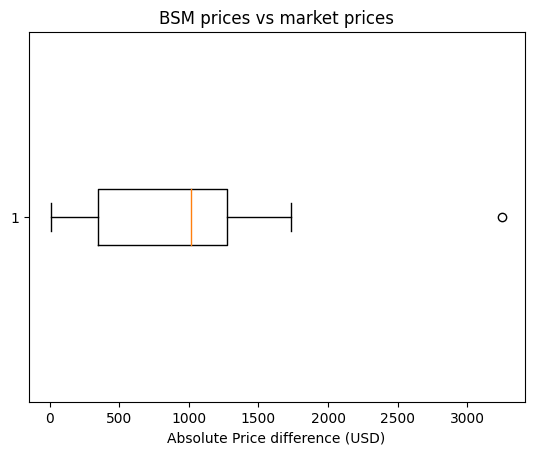

In [9]:
print("Average error mean:", abs(options_atleast_1mo_df.bsm_price - options_atleast_1mo_df.mark_price_usd).mean())
print("Average error std:", abs(options_atleast_1mo_df.bsm_price - options_atleast_1mo_df.mark_price_usd).std())
plt.title("BSM prices vs market prices");
plt.boxplot(abs(options_atleast_1mo_df.bsm_price - options_atleast_1mo_df.mark_price_usd), vert=False);
plt.xlabel("Absolute Price difference (USD)");

As mentioned before, BTC is interesting, especially regarding the option risk-free rates.

Deribit actually prices them with 0% interest rates. This is sensible since there's no way to accurately define a risk-free rate for BTC. Also to consider:
- Traditionally, risk-free rates are the safest return on an investment, often represented by government bonds. There is no government bonds issued with a BTC currency.
- Bitcoin’s Proof of Work depends on variable costs (like electricity and hardware) making it hard to establish a stable, risk-free rate. Mining rewards fluctuate, making BTC unsuitable to determine a "risk-free" benchmark.
- There is no centralized exchange for BTC. Issuance is by mining, essentially.

Therefore, we will now compute premiums on a 0% risk-free rate basis.

In [10]:
#calculate BSM prices for calls and puts
options_atleast_1mo_df['bsm_price_no_rf'] = np.where(
    #condition
    options_atleast_1mo_df['type'] == "call",
    #if condition
    bsm_call_price(
        options_atleast_1mo_df['underlying'],
        options_atleast_1mo_df['strike'],
        options_atleast_1mo_df['expiry_T'],
        0,
        options_atleast_1mo_df['historical_volatility']
    ),
    #if not condition
    bsm_put_price(
        options_atleast_1mo_df['underlying'],
        options_atleast_1mo_df['strike'],
        options_atleast_1mo_df['expiry_T'],
        0,
        options_atleast_1mo_df['historical_volatility']
    )
)

options_atleast_1mo_df['bsm_price_no_rf'] = options_atleast_1mo_df['bsm_price_no_rf'].apply(lambda p: round(p, 4))

options_atleast_1mo_df.head(10)

,type,strike,expiry,name,underlying,index_price,mark_price_btc,mark_price_usd,expiry_T,ust_rate,historical_volatility,bsm_price,bsm_price_no_rf
320446,call,57000.0,2024-07-26 09:00:00,BTC-26JUL24-57000-C,59811.5900,59301.53,0.0841,4987.2587,0.086294,0.054206,0.314056,4024.6039,3840.5726
320447,put,57000.0,2024-07-26 09:00:00,BTC-26JUL24-57000-P,59811.5900,59301.53,0.0371,2200.0868,0.086294,0.054206,0.314056,947.0073,1028.9826
320144,call,58000.0,2024-07-26 09:00:00,BTC-26JUL24-58000-C,59811.5900,59301.53,0.0742,4400.1735,0.086294,0.054206,0.314056,3360.8414,3192.2963
320145,put,58000.0,2024-07-26 09:00:00,BTC-26JUL24-58000-P,59811.5900,59301.53,0.0439,2603.3372,0.086294,0.054206,0.314056,1278.5781,1380.7063
332364,call,58000.0,2024-08-30 09:00:00,BTC-30AUG24-58000-C,60404.8189,59286.43,0.1093,6480.0068,0.182185,0.054701,0.455834,6208.6999,5889.7760
332365,put,58000.0,2024-08-30 09:00:00,BTC-30AUG24-58000-P,60404.8189,59286.43,0.0695,4120.4069,0.182185,0.054701,0.455834,3228.7402,3484.9571
286053,call,58000.0,2024-09-27 09:00:00,BTC-27SEP24-58000-C,60881.6500,59286.43,0.1351,8009.5967,0.258897,0.055018,0.488407,7872.3222,7429.6842
286054,put,58000.0,2024-09-27 09:00:00,BTC-27SEP24-58000-P,60881.6500,59286.43,0.0878,5205.3486,0.258897,0.055018,0.488407,4170.3725,4548.0342
320146,call,59000.0,2024-07-26 09:00:00,BTC-26JUL24-59000-C,59811.5900,59301.53,0.0651,3860.5296,0.086294,0.054206,0.314056,2766.9727,2615.3596
320147,put,59000.0,2024-07-26 09:00:00,BTC-26JUL24-59000-P,59811.5900,59301.53,0.0516,3059.9589,0.086294,0.054206,0.314056,1680.0426,1803.7696


Average error mean: 867.5751045454546
Average error std: 334.74119625163104


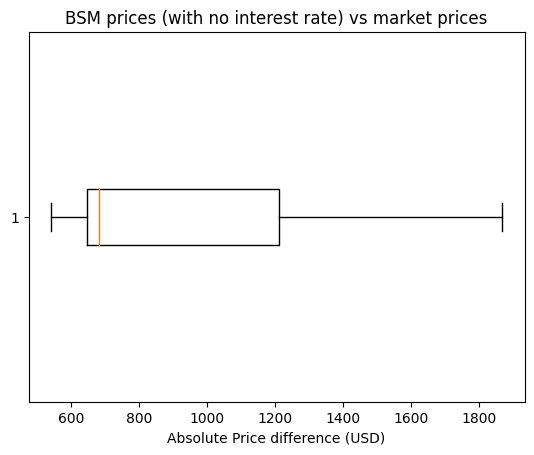

In [11]:
print("Average error mean:", abs(options_atleast_1mo_df.bsm_price_no_rf - options_atleast_1mo_df.mark_price_usd).mean())
print("Average error std:", abs(options_atleast_1mo_df.bsm_price_no_rf - options_atleast_1mo_df.mark_price_usd).std())
plt.title("BSM prices (with no interest rate) vs market prices");
plt.boxplot(abs(options_atleast_1mo_df.bsm_price_no_rf - options_atleast_1mo_df.mark_price_usd), vert=False);
plt.xlabel("Absolute Price difference (USD)");

The effects can be immediately seen: lower error between market premium and BSM premiums; spread is lower, as well.
This highlights that 0% interest rates are more appropriate for pricing BTC options.

In [12]:
options_atleast_1mo_df.drop(columns = ["ust_rate"], inplace=True)
options_atleast_1mo_df.head(5)

,type,strike,expiry,name,underlying,index_price,mark_price_btc,mark_price_usd,expiry_T,historical_volatility,bsm_price,bsm_price_no_rf
320446,call,57000.0,2024-07-26 09:00:00,BTC-26JUL24-57000-C,59811.5900,59301.53,0.0841,4987.2587,0.086294,0.314056,4024.6039,3840.5726
320447,put,57000.0,2024-07-26 09:00:00,BTC-26JUL24-57000-P,59811.5900,59301.53,0.0371,2200.0868,0.086294,0.314056,947.0073,1028.9826
320144,call,58000.0,2024-07-26 09:00:00,BTC-26JUL24-58000-C,59811.5900,59301.53,0.0742,4400.1735,0.086294,0.314056,3360.8414,3192.2963
320145,put,58000.0,2024-07-26 09:00:00,BTC-26JUL24-58000-P,59811.5900,59301.53,0.0439,2603.3372,0.086294,0.314056,1278.5781,1380.7063
332364,call,58000.0,2024-08-30 09:00:00,BTC-30AUG24-58000-C,60404.8189,59286.43,0.1093,6480.0068,0.182185,0.455834,6208.6999,5889.7760


Finally, to calculate the IV, we need to figure out what is the volatility/sigma that when used as input for our pricing model, makes it equal to the market premiums.
There are various ways to do this, but the simplest way is simply using a root finder where the function is ```f(sigma) = bsm(sigma) - market_premium``` for each contract.

In [13]:
from scipy.optimize import fsolve

#data is grouped by strike & expiry, so it's contract pairs...
previous_call_iv = None
for index, row in options_atleast_1mo_df.iterrows():
  if row['type'] == 'call':
    call_iv = fsolve(lambda sigma: bsm_call_price(row['underlying'], row['strike'], row['expiry_T'], 0, sigma) - row['mark_price_usd'], row['historical_volatility'])[0]
    call_iv = round(call_iv, 4)
    previous_call_iv = call_iv
    options_atleast_1mo_df.at[index, 'iv'] = call_iv
  elif row['type'] == 'put':
    options_atleast_1mo_df.at[index, 'iv'] = previous_call_iv

options_atleast_1mo_df.head(10)


,type,strike,expiry,name,underlying,index_price,mark_price_btc,mark_price_usd,expiry_T,historical_volatility,bsm_price,bsm_price_no_rf,iv
320446,call,57000.0,2024-07-26 09:00:00,BTC-26JUL24-57000-C,59811.5900,59301.53,0.0841,4987.2587,0.086294,0.314056,4024.6039,3840.5726,0.4970
320447,put,57000.0,2024-07-26 09:00:00,BTC-26JUL24-57000-P,59811.5900,59301.53,0.0371,2200.0868,0.086294,0.314056,947.0073,1028.9826,0.4970
320144,call,58000.0,2024-07-26 09:00:00,BTC-26JUL24-58000-C,59811.5900,59301.53,0.0742,4400.1735,0.086294,0.314056,3360.8414,3192.2963,0.4956
320145,put,58000.0,2024-07-26 09:00:00,BTC-26JUL24-58000-P,59811.5900,59301.53,0.0439,2603.3372,0.086294,0.314056,1278.5781,1380.7063,0.4956
332364,call,58000.0,2024-08-30 09:00:00,BTC-30AUG24-58000-C,60404.8189,59286.43,0.1093,6480.0068,0.182185,0.455834,6208.6999,5889.7760,0.5159
332365,put,58000.0,2024-08-30 09:00:00,BTC-30AUG24-58000-P,60404.8189,59286.43,0.0695,4120.4069,0.182185,0.455834,3228.7402,3484.9571,0.5159
286053,call,58000.0,2024-09-27 09:00:00,BTC-27SEP24-58000-C,60881.6500,59286.43,0.1351,8009.5967,0.258897,0.488407,7872.3222,7429.6842,0.5377
286054,put,58000.0,2024-09-27 09:00:00,BTC-27SEP24-58000-P,60881.6500,59286.43,0.0878,5205.3486,0.258897,0.488407,4170.3725,4548.0342,0.5377
320146,call,59000.0,2024-07-26 09:00:00,BTC-26JUL24-59000-C,59811.5900,59301.53,0.0651,3860.5296,0.086294,0.314056,2766.9727,2615.3596,0.4945
320147,put,59000.0,2024-07-26 09:00:00,BTC-26JUL24-59000-P,59811.5900,59301.53,0.0516,3059.9589,0.086294,0.314056,1680.0426,1803.7696,0.4945


Having computed the premiums, we will now choose the most common maturity and plot along the various strike prices.

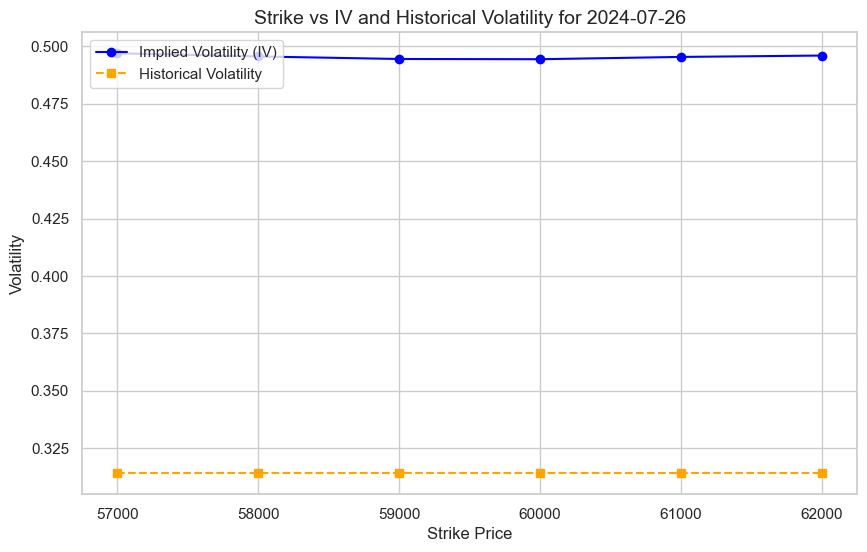

In [14]:
import seaborn as sns
sns.set(style="whitegrid")

iv_df = options_atleast_1mo_df[options_atleast_1mo_df.type == "call"][['expiry', 'strike', 'iv','historical_volatility']]
most_common_expiry = iv_df['expiry'].mode()[0]
iv_df = iv_df[iv_df['expiry'] == most_common_expiry]

plt.figure(figsize=(10, 6))
plt.plot(iv_df['strike'], iv_df['iv'], marker='o', linestyle='-', label='Implied Volatility (IV)', color='blue')
plt.plot(iv_df['strike'], iv_df['historical_volatility'], marker='s', linestyle='--', label='Historical Volatility', color='orange')
plt.title(f'Strike vs IV and Historical Volatility for {most_common_expiry.date()}', fontsize=14)
plt.xlabel('Strike Price', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.legend(loc='upper left')
plt.show()

In the figure above, we can see the main limitation of the BSM model: volatility smiles.
The BSM model assumes that the volatility of the underlying asset remains constant, and that the option volatility is not influenced by the strike price. 
That is clearly not true, as strike prices more far off the underlying price will will carry a higher real volatility, thus when increasing strike price volatility increases and doesn't remain fixed in place like the historical volatility which only changes for different maturities.

### c) Use an approach of your choice to value options and compare to traded prices. Do you find any potential opportunities? What might this say about your approach or the market?

We have already used the BSM model, which is the standard for options pricing.
Another thing we can do is use an extension to it. Since we're dealing with basically a currency option, BTC for USD, we can use an extension to BSM: the Garman-Kolhagen model.
The Garman-Kolhagen model is more robust for these types of options because it allows for the definition of specific interest rates for each currency. In our case, we will apply a 0% interest for BTC and the usual US T-Bill rate for USD.

In [15]:
def d1_garman_kolhagen(S, X, T, rd, rf, sigma):
    return (np.log(S/X) + (rd - rf + (sigma**2)/2) * T) / (sigma * np.sqrt(T))

def d2_garman_kolhagen(S, X, T, rd, rf, sigma):
    return d1_garman_kolhagen(S, X, T, rd, rf, sigma) - sigma * np.sqrt(T)

def call_garman_kolhagen(S, X, T, rd, rf, sigma):
    d1 = d1_garman_kolhagen(S, X, T, rd, rf, sigma)
    d2 = d2_garman_kolhagen(S, X, T, rd, rf, sigma)
    return S * np.exp(-rf * T) * norm.cdf(d1) - X * np.exp(-rd * T) * norm.cdf(d2)

def put_garman_kolhagen(S, X, T, rd, rf, sigma):
    d1 = d1_garman_kolhagen(S, X, T, rd, rf, sigma)
    d2 = d2_garman_kolhagen(S, X, T, rd, rf, sigma)
    return X * np.exp(-rd * T) * norm.cdf(-d2) - S * np.exp(-rf * T) * norm.cdf(-d1)

In [16]:
garman_kolhagen_prices = []

for index, row in options_atleast_1mo_df.iterrows():
    #domestic (USD) risk free rate
    rd = get_risk_free_rate(int(row['expiry_T'] * 365))
    
    #Start with null option price
    option_price = None
    
    #we're using historical volatility again but rf (BTC risk free) = 0
    if row["type"] == "call":
        option_price = call_garman_kolhagen(row['underlying'], row['strike'], row['expiry_T'], rd, rf=0, sigma=row['historical_volatility'])
    else:
        option_price = put_garman_kolhagen(row['underlying'], row['strike'], row['expiry_T'], rd, rf=0, sigma=row['historical_volatility'])
    
    #set option price
    garman_kolhagen_prices.append(round(option_price, 4))

#set garman prices
options_atleast_1mo_df['garman_kolhagen_price'] = garman_kolhagen_prices

options_atleast_1mo_df.head(10)

,type,strike,expiry,name,underlying,index_price,mark_price_btc,mark_price_usd,expiry_T,historical_volatility,bsm_price,bsm_price_no_rf,iv,garman_kolhagen_price
320446,call,57000.0,2024-07-26 09:00:00,BTC-26JUL24-57000-C,59811.5900,59301.53,0.0841,4987.2587,0.086294,0.314056,4024.6039,3840.5726,0.4970,4024.6039
320447,put,57000.0,2024-07-26 09:00:00,BTC-26JUL24-57000-P,59811.5900,59301.53,0.0371,2200.0868,0.086294,0.314056,947.0073,1028.9826,0.4970,947.0073
320144,call,58000.0,2024-07-26 09:00:00,BTC-26JUL24-58000-C,59811.5900,59301.53,0.0742,4400.1735,0.086294,0.314056,3360.8414,3192.2963,0.4956,3360.8414
320145,put,58000.0,2024-07-26 09:00:00,BTC-26JUL24-58000-P,59811.5900,59301.53,0.0439,2603.3372,0.086294,0.314056,1278.5781,1380.7063,0.4956,1278.5781
332364,call,58000.0,2024-08-30 09:00:00,BTC-30AUG24-58000-C,60404.8189,59286.43,0.1093,6480.0068,0.182185,0.455834,6208.6999,5889.7760,0.5159,6208.6999
332365,put,58000.0,2024-08-30 09:00:00,BTC-30AUG24-58000-P,60404.8189,59286.43,0.0695,4120.4069,0.182185,0.455834,3228.7402,3484.9571,0.5159,3228.7402
286053,call,58000.0,2024-09-27 09:00:00,BTC-27SEP24-58000-C,60881.6500,59286.43,0.1351,8009.5967,0.258897,0.488407,7872.3222,7429.6842,0.5377,7872.3222
286054,put,58000.0,2024-09-27 09:00:00,BTC-27SEP24-58000-P,60881.6500,59286.43,0.0878,5205.3486,0.258897,0.488407,4170.3725,4548.0342,0.5377,4170.3725
320146,call,59000.0,2024-07-26 09:00:00,BTC-26JUL24-59000-C,59811.5900,59301.53,0.0651,3860.5296,0.086294,0.314056,2766.9727,2615.3596,0.4945,2766.9727
320147,put,59000.0,2024-07-26 09:00:00,BTC-26JUL24-59000-P,59811.5900,59301.53,0.0516,3059.9589,0.086294,0.314056,1680.0426,1803.7696,0.4945,1680.0426


Looking at the respective column, we get the feeling that the Garman-Kolhagen prices are basically the same as the BSM prices using a US T-Bill risk-free rate, we can investigate this further:

Average error mean: 924.6878636363634
Average error std: 620.515407772651


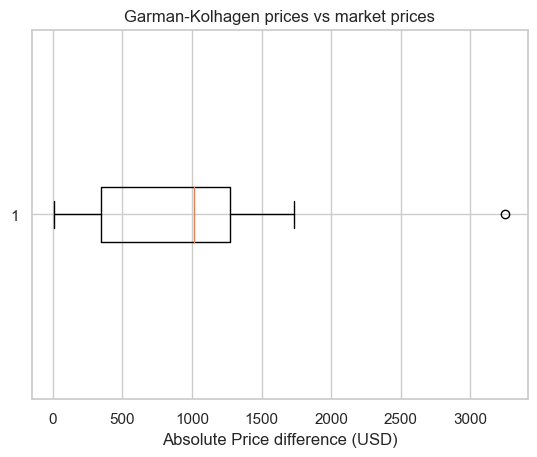

In [17]:
print("Average error mean:", abs(options_atleast_1mo_df.garman_kolhagen_price - options_atleast_1mo_df.mark_price_usd).mean())
print("Average error std:", abs(options_atleast_1mo_df.garman_kolhagen_price - options_atleast_1mo_df.mark_price_usd).std())
plt.title("Garman-Kolhagen prices vs market prices");
plt.boxplot(abs(options_atleast_1mo_df.garman_kolhagen_price - options_atleast_1mo_df.mark_price_usd), vert=False);
plt.xlabel("Absolute Price difference (USD)");

In [18]:
print((options_atleast_1mo_df['bsm_price'] - options_atleast_1mo_df['garman_kolhagen_price']).describe())
options_atleast_1mo_df.drop(columns=['garman_kolhagen_price'], inplace=True)

count    44.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
dtype: float64


Looking above we can see it's performance is the same as the BSM model mentioned. In fact, there is no difference between premiums.
This is because of a particularity of BTC: no interest rates. This makes the Garman-Kolhagen model virtually the same as BSM.

-------------------------------------
## 2) Research and  select  an alternative  model  (or  multiple  alternative models)  for cryptocurrency option  pricing.  It  might  not  surprise  you  to  find  a  number  of  different  approaches  have  been tested,  take  a  look  in  the  literature  and  select  the  model(s)  that  you  believe  are  the  most promising. For example, you could look at improving the modelling of volatility or using machine learning to estimate prices. You can look at methods from traditional finance or those specific to cryptocurrencies. If you need a starting point, you can take a look at the review paper from Almeida,  J.,  &  Gonçalves,  T.  C.  (2022).  A  systematic  literature  review  of  volatility  and  risk management on cryptocurrency investment: A methodological point of view. Risks, 10(5), 107. Remember you don’t need to test all the options listed just a few alternatives you believe are promising.

### a)  Explain your approach and the theoretical advantages over Black-Scholes-Merton.

Other than the Black-Scholes model, another methodology is the Heston model which assumes that the volatility in the underlying asset is not constant which can alleviate that limitation of  constant volatility throughout the tenor by incorporating stochastic volatility to the model.

The Heston model is determined according to a couple of stochastic differential equations. The first one defines the relationship for developing the asset price and the second equation defines the relationship for the volatility. Thus, the asset price process consists of deterministic drift term, incorporating the information obtained from the past price movements, and the stochastic diffusion term depending on the volatility process.

Its usable parameters are V0, the initial variance, theta, the long-term variance, kappa the mean reversion speed, sigma, the volatility of variance, and rho the correlation between the two Brownian motions driving the asset price as well as the variance. These parameters are learnt from historical data, which enables the model to run different conditions of the market.

For the actual implementation, the Heston model can be solved numerically and the partial differential equations derived can be solved using a Monte Carlo method.

### b)  Fit the model(s) and compare your pricing results. How do they compare to the market and those previously derived? Can you draw any insights?

We can start by defining the functions to get the historical returns and the Heston parameters:

In [19]:
import yfinance as yf
import statsmodels.api as sm

def get_returns(days):
    return np.log(
        (yf.download('BTC-USD', progress=False)['Adj Close'].iloc[-days:].pct_change() + 1).dropna()
    )

def get_params(returns):
    V0, theta, kappa, sigma, rho = 0, 0, 0, 0, 0
    
    # Calculate daily realized variance
    window = 7 #weekly window
    # Align the returns and realized variance data
    realized_variance = (returns.rolling(window).var() * 252).dropna()
    aligned_returns = returns.loc[realized_variance.index]
    aligned_realized_variance = realized_variance
    
    # Initial variance (V0)
    V0 = aligned_realized_variance.iloc[0]

    # Long-term variance (theta)
    theta = aligned_realized_variance.mean()

    # Fit an autoregressive model to estimate kappa and sigma
    # AR(1) model: RV[t+1] = a + b * RV[t] + epsilon
    endog = aligned_realized_variance[1:].reset_index(drop=True)
    exog = sm.add_constant(aligned_realized_variance[:-1].reset_index(drop=True))
    model = sm.OLS(endog, exog).fit()
    a, b = model.params

    # Mean reversion speed (kappa)
    kappa = -np.log(b) / window

    # Volatility of variance (sigma)
    sigma = model.resid.std() * np.sqrt(2 * kappa)

    # Correlation between returns and realized variance
    rho = np.corrcoef(aligned_returns[1:].values, np.sqrt(aligned_realized_variance[:-1].values))[0, 1]
        
    return { "V0": V0, "theta": theta, "kappa": kappa, "sigma": sigma, "rho": rho }



Next, we incorporate the parameters and the stochastic equations in a Monte Carlo simulation to compute the prices:

In [20]:
def heston_model(S0, K, T, N, r, params, iters, type):
    V0 = params['V0']
    theta = params['theta']
    kappa = params['kappa']
    sigma = params['sigma']
    rho = params['rho']
    #M = N; N = iters
    dt = 0.01
    S = np.zeros((N+1, iters))
    V = np.zeros((N+1, iters))
    S[0], V[0] = S0, V0
    
    for t in range(1, N+1):
        z1 = np.random.normal(0, 1, iters)
        z2 = np.random.normal(0, 1, iters)
        W1 = np.sqrt(dt) * z1
        W2 = rho * W1 + np.sqrt(1 - rho ** 2) * np.sqrt(dt) * z2
        V[t] = np.maximum(
            V[t - 1] + kappa * (theta - V[t - 1]) * dt + sigma * np.sqrt(V[t - 1]) * W2,
            0
        )
        S[t] = S[t - 1] * np.exp((r - 0.5 * V[t - 1]) * dt + np.sqrt(V[t - 1]) * W1)
    
    if type == "call":
        payoff = np.maximum(S[-1] - K, 0)
    else:
        payoff = np.maximum(K - S[-1], 0)
    
    return np.exp(-r * T) * np.mean(payoff)
    
    

In [21]:
heston_prices = []
for index, row in options_atleast_1mo_df.iterrows():
    #get days & params
    N = int(row['expiry_T'] * 365)
    returns = get_returns(N)
    params = get_params(returns)
    #compute & append price
    price = heston_model(row['underlying'], row['strike'], row['expiry_T'], N, 0, params, 100000, row['type'])
    heston_prices.append(price)

options_atleast_1mo_df['heston_price'] = heston_prices
options_atleast_1mo_df.head(10)

,type,strike,expiry,name,underlying,index_price,mark_price_btc,mark_price_usd,expiry_T,historical_volatility,bsm_price,bsm_price_no_rf,iv,heston_price
320446,call,57000.0,2024-07-26 09:00:00,BTC-26JUL24-57000-C,59811.5900,59301.53,0.0841,4987.2587,0.086294,0.314056,4024.6039,3840.5726,0.4970,4143.045926
320447,put,57000.0,2024-07-26 09:00:00,BTC-26JUL24-57000-P,59811.5900,59301.53,0.0371,2200.0868,0.086294,0.314056,947.0073,1028.9826,0.4970,1342.826431
320144,call,58000.0,2024-07-26 09:00:00,BTC-26JUL24-58000-C,59811.5900,59301.53,0.0742,4400.1735,0.086294,0.314056,3360.8414,3192.2963,0.4956,3520.503572
320145,put,58000.0,2024-07-26 09:00:00,BTC-26JUL24-58000-P,59811.5900,59301.53,0.0439,2603.3372,0.086294,0.314056,1278.5781,1380.7063,0.4956,1732.717930
332364,call,58000.0,2024-08-30 09:00:00,BTC-30AUG24-58000-C,60404.8189,59286.43,0.1093,6480.0068,0.182185,0.455834,6208.6999,5889.7760,0.5159,6898.240864
332365,put,58000.0,2024-08-30 09:00:00,BTC-30AUG24-58000-P,60404.8189,59286.43,0.0695,4120.4069,0.182185,0.455834,3228.7402,3484.9571,0.5159,4502.361203
286053,call,58000.0,2024-09-27 09:00:00,BTC-27SEP24-58000-C,60881.6500,59286.43,0.1351,8009.5967,0.258897,0.488407,7872.3222,7429.6842,0.5377,10199.043598
286054,put,58000.0,2024-09-27 09:00:00,BTC-27SEP24-58000-P,60881.6500,59286.43,0.0878,5205.3486,0.258897,0.488407,4170.3725,4548.0342,0.5377,7352.156087
320146,call,59000.0,2024-07-26 09:00:00,BTC-26JUL24-59000-C,59811.5900,59301.53,0.0651,3860.5296,0.086294,0.314056,2766.9727,2615.3596,0.4945,2973.605283
320147,put,59000.0,2024-07-26 09:00:00,BTC-26JUL24-59000-P,59811.5900,59301.53,0.0516,3059.9589,0.086294,0.314056,1680.0426,1803.7696,0.4945,2148.995461


Average error mean: 1135.7480386120353
Average error std: 1053.1760342066007


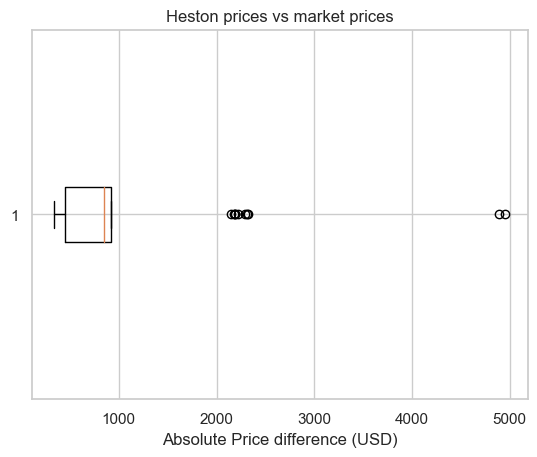

In [22]:
print("Average error mean:", abs(options_atleast_1mo_df.heston_price - options_atleast_1mo_df.mark_price_usd).mean())
print("Average error std:", abs(options_atleast_1mo_df.heston_price - options_atleast_1mo_df.mark_price_usd).std())
plt.title("Heston prices vs market prices");
plt.boxplot(abs(options_atleast_1mo_df.heston_price - options_atleast_1mo_df.mark_price_usd), vert=False);
plt.xlabel("Absolute Price difference (USD)");

Looking above, we can see that in some cases it very nearly matched the actual market prices but in others it has a huge spread.
Overall, this method even though it incorporates stochastic volatility, did not perform as well as traditional models.

--------------------------------------------------------------------------------------------